<a href="https://colab.research.google.com/github/tomdyer10/wine_expert/blob/master/visualising_predictions_1_embedding_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook visualises the outputs of the embedding layer and overall model prediction probabilities across the 27 classes.

# Load Learner

In [0]:
from fastai.text import *
import pandas as pd 
import numpy as np

In [0]:
data_lm = load_data('drive/My Drive/wine_reviews', file='data/region_clas_data_lm')
data_clas = load_data('drive/My Drive/wine_reviews', file='data/region_clas_data_clas')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load('region_classifier/fifth')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (86085 items)
x: TextList
xxbos xxmaj aromas include tropical fruit , broom , brimstone and dried herb . xxmaj the palate is n't overly expressive , offering unripened apple , citrus and dried sage alongside brisk acidity .,xxbos xxmaj tart and snappy , the flavors of lime flesh and rind dominate . xxmaj some green pineapple pokes through , with crisp acidity underscoring the flavors . xxmaj the wine was all stainless - steel fermented .,xxbos xxmaj pineapple rind , lemon pith and orange blossom start off the aromas . xxmaj the palate is a bit more opulent , with notes of honey - drizzled guava and mango giving way to a slightly astringent , semidry finish .,xxbos xxmaj much like the regular bottling from 2012 , this comes across as rather rough and tannic , with rustic , earthy , herbal characteristics . xxmaj nonetheless , if you think of it as a pleasantly unfussy country wine , it 's a good companion to a hearty winter stew .,xxb

# Visualizing Embedding Layer

Can we group similarly categorised sample data together in embedding space? 

In [0]:
learn.model


SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(13680, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(13680, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, 

Extract embedding layer and defining a function to output the embeddings

In [0]:
embedding_layer = learn.model[0]._modules['module']._modules['encoder_dp']

In [0]:
#create tokenizer for review sequences
x, y = learn.data.one_item('this is a sweet wine')

In [0]:
emb = embedding_layer(x)
pred = learn.predict('this is a sweet wine from north')

In [0]:
emb[0][0], pred[0]

(tensor([-3.1171e-01, -6.1616e-01,  1.0309e+00,  1.7068e+00, -2.0862e+00,
         -3.1386e-01, -1.5408e-01, -3.4999e-01, -1.5865e+00, -4.1848e-01,
          1.2592e+00,  9.7126e-01,  7.3329e-01, -4.0388e-01, -7.8212e-02,
          2.3598e+00,  3.6684e-02,  3.3645e-01,  1.2555e+00,  1.7763e+00,
          1.5642e+00,  1.2684e+00,  8.9761e-01, -2.3313e-01,  7.6023e-01,
          7.9434e-01, -5.7285e-01, -1.4158e-01,  1.4506e+00,  1.1226e+00,
         -8.8570e-01,  7.7776e-01, -5.3519e-01,  1.1401e+00, -1.0581e+00,
         -7.5614e-01,  7.5358e-01, -1.5036e-01, -2.7125e-01, -8.4000e-01,
         -7.5405e-01,  6.4593e-01,  1.8043e+00, -2.5323e-01,  5.6178e-01,
          7.4710e-01, -2.4306e-01, -2.8335e-01, -1.0530e+00,  5.1000e-02,
          1.9124e+00, -5.7362e-02,  7.9456e-01,  2.4878e-01,  9.5316e-01,
         -8.6620e-02,  1.9032e-02,  1.0338e+00, -1.0981e+00,  9.3376e-01,
         -1.2941e+00, -9.7082e-01, -1.5958e+00, -1.4058e+00,  2.5765e-02,
          7.6716e-01, -1.0795e+00,  1.

Embeddings can be important in model interpretability - particularly in CNNs - see inspiration from this blog by google AI https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

Output embeddings layers of validiation set

In [0]:
data = data_clas
embeddings = []
predictions = []
for i in data.valid_ds:
  p = learn.predict(i[0])[1]
  predictions.append(p.item())
  x,_ = learn.data.one_item(i[0])
  embeddings.append(embedding_layer(x)[0][0])


In [0]:
embed = [t.numpy() for t in embeddings]

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=10000)
tsne_results = tsne.fit_transform(embed)

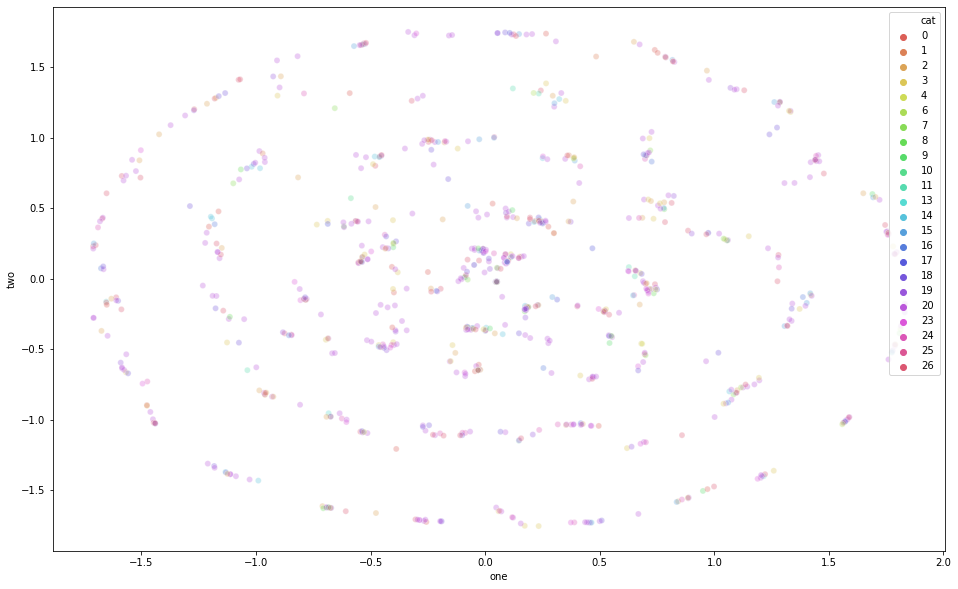

In [0]:
import seaborn as sns

df_sub = pd.DataFrame()

df_sub['one'] = tsne_results[:,0]
df_sub['two'] = tsne_results[:,1]
df_sub['cat'] = predictions

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="one", y="two",
    hue='cat',
    palette=sns.color_palette("hls", 23),
    data=df_sub,
    legend="full",
    alpha=0.3
)

We see some grouping but no real colour specific grouping here. This has not really improved the interpretability of our model.

# tSNE Over Prediction Probabilities 

Can we visualise similar classes here better than before?

In [0]:
preds = learn.get_preds(data_clas.valid_ds)

In [0]:
probs = [t.numpy() for t in preds]

In [0]:
probs_trans = TSNE(n_components=2, perplexity=15).fit_transform(probs)

In [0]:
x = [i[0] for i in probs_trans]
y = [i[1] for i in probs_trans]

In [0]:
data_clas.classes
labels = [data_clas.classes[i] for i in preds[1]]

In [0]:
len(labels), len(x)

(86085, 86085)

Create dataframe from calculated tSNE coordinates

In [0]:
prob_df = pd.DataFrame.from_dict({'x': x, 'y': y, 'label': labels})

In [0]:
prob_df.head()

,x,y,label
0,24.242626,36.154095,Italy - Sicily & Sardinia
1,4.123683,-53.238846,US - Oregon
2,-50.961853,-19.454826,US - Michigan
3,-10.874167,-53.799889,US - Oregon
4,16.638344,26.288404,Italy - Sicily & Sardinia


Plot tSNE

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


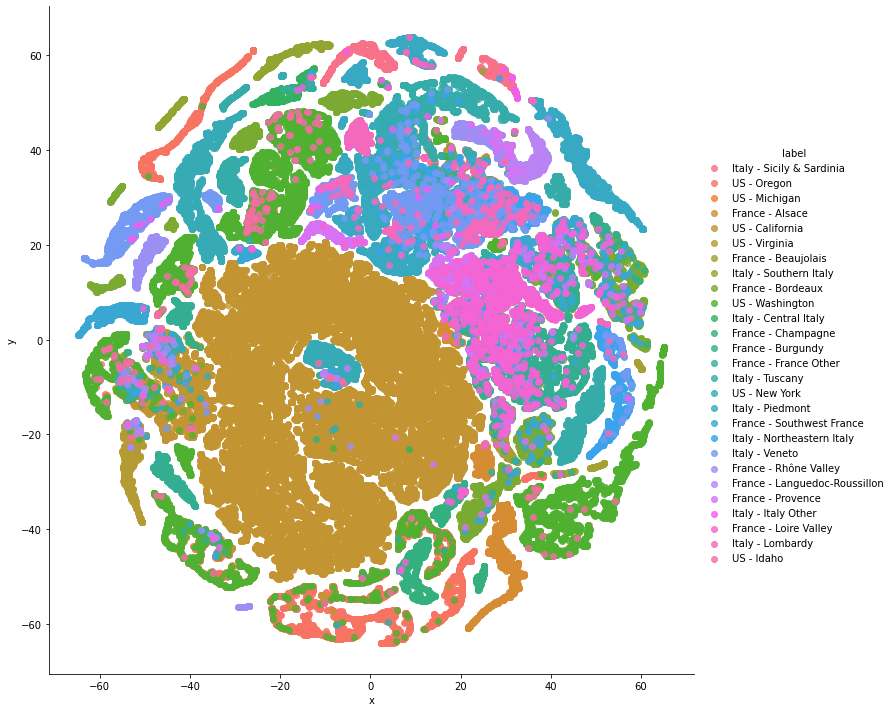

In [0]:
import seaborn as sns

g = sns.lmplot('x', 'y', data=prob_df, hue='label', fit_reg=False, legend=True, size=10)

This is a great visualisation of the groupings of predictions.

It shows clear boundaries between classes, with some classes much more closely neighbouring others. 

This is a fantastic starting point for improving understanding of wine regions and their characteristics. 

It is beyond the scope of this project currently, but it would be an interesting project to investigate similar phrases between neighbouring areas as well as other factors such as temperature and rainfall, to see if they are reflected in the above grouping.

Visualising the same data by country

In [0]:
prob_df['country'] = prob_df['label'].apply(lambda x: x.split('-')[0])

In [0]:
prob_df.head()

,x,y,label,country
0,24.242626,36.154095,Italy - Sicily & Sardinia,Italy
1,4.123683,-53.238846,US - Oregon,US
2,-50.961853,-19.454826,US - Michigan,US
3,-10.874167,-53.799889,US - Oregon,US
4,16.638344,26.288404,Italy - Sicily & Sardinia,Italy


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


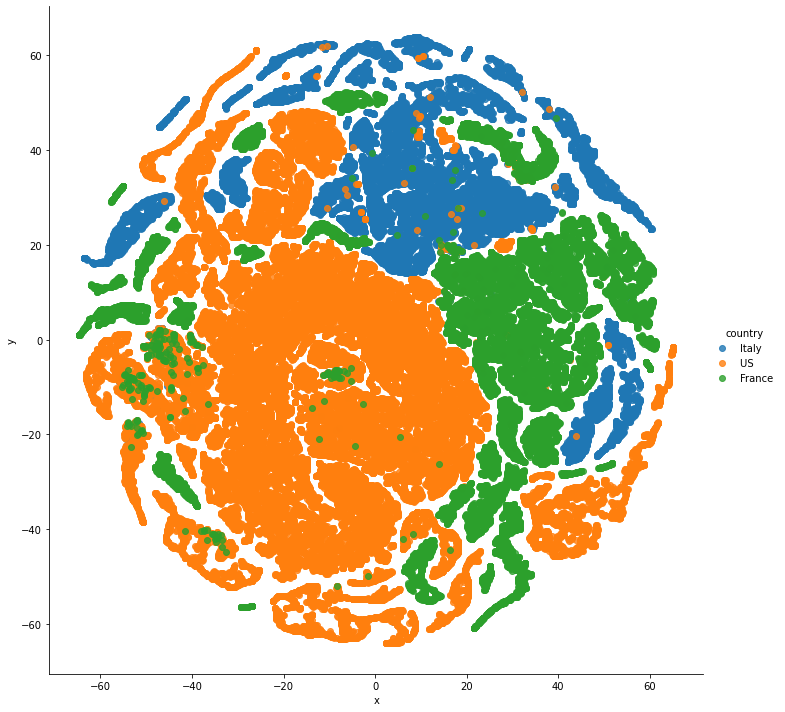

In [0]:
c = sns.lmplot('x', 'y', data=prob_df, hue='country', fit_reg=False, legend=True, size=10)

In [0]:
c.savefig('country_tsne.jpg')

In [0]:
g.savefig('region_tsne.jpg')